<a href="https://colab.research.google.com/github/DeguShi/AI-notebooks/blob/main/algorithm-Astar-mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 1:



In [ ]:
import pandas as pd
import numpy as np

try: import folium
except:
    !pip install folium
from folium.plugins import MarkerCluster

from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
import heapq
import time
import pickle
from sklearn.metrics.pairwise import haversine_distances
from IPython.display import display
import os


if not os.path.exists('alagamentos.xlsx'): # baixando os dados só na primeira run, achei melhor assim
    !gdown 1K0tu3E-kcu7ikQcyNnKixjCY8vSjvxgl -O alagamentos.xlsx

print("Bibliotecas e dataset importados!")

# Carrego todo dadaset primeiro e separo os dados em um jeito que fica mais facil extrair as informações depois

df_base = pd.read_excel('alagamentos.xlsx')
df_base[['lat', 'lon']] = df_base['localidade'].str.split(",", expand=True).astype(float)
df_base['cidade'] = df_base['descricao']


df_base

Bibliotecas e dataset importados!


,descricao,localidade,lat,lon,cidade
0,Chuvas deixam cidade de SP em estado de atençã...,"-23.567387,-46.570383",-23.567387,-46.570383,Chuvas deixam cidade de SP em estado de atençã...
1,Chuva em SP deixa linha de trem e trecho de ro...,"-23.567387,-46.570383",-23.567387,-46.570383,Chuva em SP deixa linha de trem e trecho de ro...
2,Cidade de São Paulo entra em estado de atenção...,"-23.567387,-46.570383",-23.567387,-46.570383,Cidade de São Paulo entra em estado de atenção...
3,"Chuva em SP causa queda de árvores, alagamento...","-23.567387,-46.570383",-23.567387,-46.570383,"Chuva em SP causa queda de árvores, alagamento..."
4,São Paulo registra 18ª morte por causa das chu...,"-23.567387,-46.570383",-23.567387,-46.570383,São Paulo registra 18ª morte por causa das chu...
...,...,...,...,...,...
11939,Chuva forte e ventos intensos trazem alerta ao...,"-21.210591,-41.886203",-21.210591,-41.886203,Chuva forte e ventos intensos trazem alerta ao...
11940,Afetados por chuvas receberão auxílio nas próx...,"-21.210591,-41.886203",-21.210591,-41.886203,Afetados por chuvas receberão auxílio nas próx...
11941,Fortes chuvas causam alagamentos em Bom Jesus ...,"-21.210591,-41.886203",-21.210591,-41.886203,Fortes chuvas causam alagamentos em Bom Jesus ...
11942,BR-101 é interditada nos dois sentidos em Camp...,"-21.210591,-41.886203",-21.210591,-41.886203,BR-101 é interditada nos dois sentidos em Camp...


# Preciso add exemplicação para a haver depois



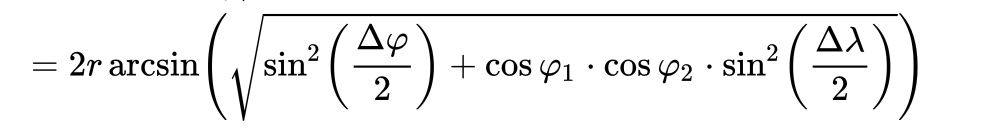

In [ ]:
# Funcao haversine para calcular a distancia entre cidades

def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1_rad = radians(lat1)
    lat2_rad = radians(lat2)
    a = sin(dLat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dLon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [ ]:
# Como existem muitas notícias sobre uma mesma coord, vou dar um groupby e trabalhar só informações únicas

df_unicos = df_base.groupby(['lat', 'lon'], as_index=False).first()

# Dados para facilitar testagem entre samples e controle de geração:

AUTONOMIA = 750.0 # distancia que o drone consegue viajar por trecho
RANDOM_SEED = 42
SAMPLE_SIZE = 1000 # eu segui esse tamanho porque estava inicialmente assim no .ipynb da descrição da atividade

unique_sample_size = min(SAMPLE_SIZE, len(df_unicos))
df = df_unicos.sample(unique_sample_size, random_state=RANDOM_SEED).reset_index(drop=True)

# Aqui eu suponho que tenha um jeito inteligente para fazer isso, mas eu optei por fazer esse dicionário manualmente:

capitais_coords_map = {
    'Aracaju':        (-10.907216, -37.048213), 'Belém':          (-1.459845,  -48.487826),
    'Belo Horizonte': (-19.937524, -43.926453), 'Boa Vista':      (2.816682,   -60.670533),
    'Brasília':       (-15.779720, -47.929720), 'Campo Grande':   (-20.448610, -54.629720),
    'Cuiabá':         (-15.598890, -56.094720), 'Curitiba':       (-25.429720, -49.271940),
    'Florianópolis':  (-26.304518,-48.849409), 'Fortaleza':      (-3.731940,  -38.526670),
    'Goiânia':        (-16.680000, -49.255000), 'João Pessoa':    (-7.119440,  -34.863060),
    'Macapá':         (0.038890,   -51.066390), 'Maceió':         (-9.665830,  -35.735280),
    'Manaus':         (-3.118890,  -60.025000), 'Natal':          (-5.794440,  -35.209440),
    'Palmas':         (-10.167500, -48.331670), 'Porto Alegre':   (-30.033060, -51.230000),
    'Porto Velho':    (-8.761940,  -63.903890), 'Recife':         (-8.054170,  -34.881390),
    'Rio Branco':     (-9.974720,  -67.810000), 'Rio de Janeiro': (-22.871251,-43.775041),
    'Salvador':       (-12.971110, -38.510830), 'São Luís':       (-2.529720,  -44.302780),
    'São Paulo':      (-23.550520, -46.633308), 'Teresina':       (-5.090000,  -42.810000),
    'Vitória':        (-20.319440, -40.337780)
}

# Agora eu defino quais cidades unicas são capitais, isso é relavante tanto para o calculo de rota quanto para representação grafica

nome_cap_para_id = {}
df['is_cap'] = False


cap_dic = pd.DataFrame(capitais_coords_map.items(), columns=['NomeCap', 'Coords'])
cap_dic[['cap_lat', 'cap_lon']] = pd.DataFrame(cap_dic['Coords'].tolist(), index=cap_dic.index)


# agora eu mapeio os dados do df de modo a categorizar as capitais com o dicionário que fiz acima:

for index, cap_linha in cap_dic.iterrows():
  distancias = df.apply(lambda linha: haversine(cap_linha['cap_lat'], cap_linha['cap_lon'], linha['lat'], linha['lon']), axis=1)
  index_no_df = distancias.idxmin()
  if index_no_df not in nome_cap_para_id.values() and distancias.min() <10:
    nome_cap_para_id[cap_linha['NomeCap']] = index_no_df
    df.loc[index_no_df, 'is_cap'] = True
    df.loc[index_no_df, 'cidade'] = cap_linha['NomeCap']

# Só informa os dados classificados até então

print(f"\n{len(df)} cidades unicas (Sample {unique_sample_size}, Seed {RANDOM_SEED}).")
print(f"{len(nome_cap_para_id)} capitais identificadas na amostra e mapeadas:")
print(nome_cap_para_id)

# Agora crio um set para as capitais (para verificar dados mais rapido) e um pkl para cache de distacias min até um capital depois

id_set_cap = set(nome_cap_para_id.values())

dist_min_cap_file = f'dist_min_capital_s{len(df)}_r{RANDOM_SEED}.pkl'
if os.path.exists(dist_min_cap_file): os.remove(dist_min_cap_file)

df


318 cidades unicas (Sample 318, Seed 42).
26 capitais identificadas na amostra e mapeadas:
{'Aracaju': 296, 'Belém': 68, 'Belo Horizonte': 36, 'Boa Vista': 311, 'Brasília': 257, 'Cuiabá': 309, 'Curitiba': 144, 'Florianópolis': 167, 'Fortaleza': 87, 'Goiânia': 142, 'João Pessoa': 146, 'Macapá': 291, 'Maceió': 175, 'Manaus': 34, 'Natal': 164, 'Palmas': 73, 'Porto Alegre': 224, 'Porto Velho': 194, 'Recife': 297, 'Rio Branco': 180, 'Rio de Janeiro': 267, 'Salvador': 178, 'São Luís': 75, 'São Paulo': 81, 'Teresina': 240, 'Vitória': 32}


,lat,lon,descricao,localidade,cidade,is_cap
0,-23.468506,-46.531084,Concessionária de carros de luxo fica completa...,"-23.468506,-46.531084",Concessionária de carros de luxo fica completa...,False
1,-5.352606,-49.142025,Enchentes em 3 cidades do Pará deixam famílias...,"-5.352606,-49.142025",Enchentes em 3 cidades do Pará deixam famílias...,False
2,-26.991819,-48.634617,Veja imagens dos alagamentos em Balneário Camb...,"-26.991819,-48.634617",Veja imagens dos alagamentos em Balneário Camb...,False
3,-7.828372,-34.910583,Prefeita de Igarassu fala sobre situação do mu...,"-7.828372,-34.910583",Prefeita de Igarassu fala sobre situação do mu...,False
4,-29.759823,-57.081825,Prejuízos e alagamento: funcionários de instit...,"-29.759823,-57.081825",Prejuízos e alagamento: funcionários de instit...,False
...,...,...,...,...,...,...
313,-19.224346,-42.605661,Abrigos provisórios para moradores de áreas de...,"-19.224346,-42.605661",Abrigos provisórios para moradores de áreas de...,False
314,-23.499323,-47.457853,FOTOS: Chuva causa alagamentos e transtornos e...,"-23.499323,-47.457853",FOTOS: Chuva causa alagamentos e transtornos e...,False
315,-22.858395,-47.221097,Chuva intensa em Hortolândia causa alagamentos...,"-22.858395,-47.221097",Chuva intensa em Hortolândia causa alagamentos...,False
316,-6.214964,-36.688662,"Temporal deixa Baixada Santista, SP, debaixo d...","-6.214964,-36.688662","Temporal deixa Baixada Santista, SP, debaixo d...",False


# Grafo

In [ ]:
# Agora eu vou começar a preparar os dados para criar um grafo a partir do df

coords_rad = np.radians(df[['lat', 'lon']].values)
matriz_dist_km = haversine_distances(coords_rad, coords_rad)*6371.0

print("Matriz de distâncias pronta.")



graph = {i: [] for i in df.index}

indices_i, indices_j = np.where((matriz_dist_km <= AUTONOMIA) & (matriz_dist_km > 0))

for i, j in zip(indices_i, indices_j):
    dist = matriz_dist_km[i,j]
    graph[df.index[i]].append((df.index[j], dist))

print("Grafo pronto.\n")

# Isso vai me ajudar para quando eu for montar meu  "A*" mais a diante :D

grau_nos = {node_idx: len(v) for node_idx, v in graph.items()}

for i in df.index:
  if i not in graph:
    grau_nos[i] = 0

print("Grau dos nos calculados\n")

Matriz de distâncias pronta.
Grafo pronto.

Grau dos nos calculados



In [ ]:
# estava achando estranho a dist de RJ e FL ser curta suficiente para existir uma aresta entre elas


idx_rj_df = nome_cap_para_id.get('Rio de Janeiro')
idx_flo_df = nome_cap_para_id.get('Florianópolis')

if idx_rj_df is not None and idx_flo_df is not None:
    print(f"Índice de RJ no df: {idx_rj_df}")
    print(f"Índice de FL no df: {idx_flo_df}")
else:
    print("RJ ou FLO não presntes")



if idx_rj_df is not None and idx_flo_df is not None:
    coords_rj_no_df = df.loc[idx_rj_df, ['lat', 'lon']]
    coords_flo_no_df = df.loc[idx_flo_df, ['lat', 'lon']]
    print(f"Coordenadas de RJ no df: lat={coords_rj_no_df['lat']}, lon={coords_rj_no_df['lon']}")
    print(f"Coordenadas de FL no df: lat={coords_flo_no_df['lat']}, lon={coords_flo_no_df['lon']}")


if idx_rj_df is not None and idx_flo_df is not None:
  distancia_na_matriz = matriz_dist_km[idx_rj_df, idx_flo_df]
  print(f"dist rj-fl direto da matriz_dist_km: {distancia_na_matriz:.10f} km")


if idx_rj_df is not None and idx_flo_df is not None:
  # Com sua função haversine
  dist_manual_com_coords_df = haversine(coords_rj_no_df['lat'], coords_rj_no_df['lon'],
                                        coords_flo_no_df['lat'], coords_flo_no_df['lon'])
  print(f"dist com a minha haversine: {dist_manual_com_coords_df:.10f} km")

  # Com sklearn
  coords_rj_df_rad = np.radians(np.array([[coords_rj_no_df['lat'], coords_rj_no_df['lon']]]))
  coords_flo_df_rad = np.radians(np.array([[coords_flo_no_df['lat'], coords_flo_no_df['lon']]]))
  dist_sklearn_com_coords_df = haversine_distances(coords_rj_df_rad, coords_flo_df_rad)[0][0] * 6371.0
  print(f"dist com a haversine_dist printa da sk: {dist_sklearn_com_coords_df:.10f} km")

Índice de RJ no df: 267
Índice de FL no df: 167
Coordenadas de RJ no df: lat=-22.871251, lon=-43.775041
Coordenadas de FL no df: lat=-26.304518, lon=-48.849409
dist rj-fl direto da matriz_dist_km: 639.4026807773 km
dist com a minha haversine: 639.4026807773 km
dist com a haversine_dist printa da sk: 639.4026807773 km


In [ ]:
# Algumas definições para calcular a profundidade de busca:

# Eu defini meio que arbitrariamente durante meus testes o que eu considerava uma celula em regiao densa e uma celula em regiao esparsa
# isso é fundamental para eu conseguir variar minha profundidade de busca de maneira otimizada
# para cada nó depois. As cidades escolhidas foram SP e POA porque durante minhas testagens, eu achava 211 cidades na rota partindo de SP
# e somente 190 cidades partindo de POA, isso não fazia sentido para mim, pois se eu chego em POA a partir de SP e encontro 211, o contrário
# deveria ser verdade também. Eu conclui que o problema provavelmente é o fato que a profundidade alta no final da busca consume muito poder
# computacional e memória em geral, pois eu fico guardando muita informação nas minhas iteracoes, para resolver isso eu testei POA com profundidade
# maior e cheguei nas 211 cidades que eu queria, isso abriu meus olhos para uma maneira de otimizar a busca.

idx_sp = nome_cap_para_id.get('São Paulo', -1)
idx_poa = nome_cap_para_id.get('Porto Alegre', -1)

grau_sp = grau_nos.get(idx_sp, -1) if idx_sp != -1 else -1
grau_poa = grau_nos.get(idx_poa, -1) if idx_poa != -1 else -1

# Valores que obtive enquanto testava profundidades fixas manualmente

DEPTH_SP = 5
DEPTH_POA = 15

MIN_OPT_DEPTH = 3
MAX_OPT_DEPTH = 20


print("Referências para profundidade otimizada:")
if grau_sp != -1: print(f"São Paulo: Grau = {grau_sp}, prof: {DEPTH_SP}")
else: print(f"São Paulo não encontrada para referência de grau.")
if grau_poa != -1: print(f"Porto Alegre: Grau = {grau_poa}, prof: {DEPTH_POA}")
else: print(f"Porto Alegre não encontrada para referência de grau.")

Referências para profundidade otimizada:
São Paulo: Grau = 175, prof: 5
Porto Alegre: Grau = 48, prof: 15


In [ ]:
# Funcao para calculo da profundidade de fato:

def calcular_profundidade_opt(cur_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp):

  # Se o sample tiver algum problema com as referencias que escolhi:

  if g_sp == -1 or g_poa ==  -1 or g_sp == g_poa:
    return (min_dp+max_dp)//2 # usa uma média para trabalhar

  # A ideia em si é simples, eu queria que um no em uma região de alta densidade tivesse profundidade baixa
  # e o contrário também fosse verdade. Sendo assim:

  m = (dp_poa-dp_sp)/(g_poa-g_sp)

  c = dp_sp-m*g_sp

  dp_calculada = m*cur_grau+c

  dp_final = int(round(np.clip(dp_calculada, min_dp, max_dp)))

  return dp_final


print("Calculo de graus e profundidade otimizada prontos.")

Calculo de graus e profundidade otimizada prontos.


In [ ]:
# Agora eu faço as funcoes que vou usar para pre calcular os menores caminhos:

def dijkstra_menor_caminho(g_dic, start_id):
  id_nos_df = list(df.index)
  open_set = [(0, start_id)]
  heapq.heapify(open_set)

  g_score = {idx: float('inf') for idx in id_nos_df}

  if start_id in g_score: g_score[start_id] = 0
  else: return {idx: float('inf') for idx in id_nos_df}

  while open_set:
    cur_g, cur = heapq.heappop(open_set)

    if cur_g > g_score.get(cur, float('inf')): continue

    for v, d in g_dic.get(cur, []):
      if v not in g_score: continue
      temp_g = cur_g + d
      if temp_g < g_score[v]:
        g_score[v] = temp_g
        heapq.heappush(open_set, (temp_g, v))
  return g_score

print("Dijkstra feito.")



def pre_calcular_dist_to_capital(g_dic, id_cap_p_set, nos_df, filename):
  print("Pré calculando distancias para capitais...")

  dist_todas_cap = {}
  for id_cap in tqdm(id_cap_p_set, desc="calculando dijkstra para as cap"):
    dist_da_cap = dijkstra_menor_caminho(g_dic, id_cap)
    dist_todas_cap[id_cap] = dist_da_cap

  dist_min_cap_dic = {idx: float('inf') for idx in nos_df.index}
  for id_no in tqdm(nos_df.index, desc="calculando menor dist"):
    min_dist = float('inf')


    for id_cap in id_cap_p_set:
      dist = dist_todas_cap[id_cap].get(id_no, float('inf'))
      if dist < min_dist: min_dist = dist

    dist_min_cap_dic[id_no] = min_dist

  # salva essas distancias durante a exec para não precisar repetir no mesmo sample
  with open(filename, 'wb')as f: pickle.dump(dist_min_cap_dic, f)
  print(f"Funcao de pre calculo pronta e salva em '{filename}'.")

  return dist_min_cap_dic


#salva tudo
dist_min_cap_filename_global = f'dist_min_capital_s{len(df)}_r{RANDOM_SEED}.pkl'


if not id_set_cap:
    print("Deu algum erro na classificacao de cap, no id_set não tem nada.")
    dist_min_cap = {idx: float('inf') for idx in df.index}
else:
    try:
        with open(dist_min_cap_filename_global, 'rb') as f: dist_min_cap = pickle.load(f)
        if len(dist_min_cap) != len(df):
             dist_min_cap = pre_calcular_dist_to_capital(graph, id_set_cap, df, dist_min_cap_filename_global)
    except FileNotFoundError:
        dist_min_cap = pre_calcular_dist_to_capital(graph, id_set_cap, df, dist_min_cap_filename_global)
print("Distâncias mínimas às capitais prontas.")

Dijkstra feito.
Pré calculando distancias para capitais...


calculando menor dist: 100%|██████████| 318/318 [00:00<00:00, 58150.09it/s]

Funcao de pre calculo pronta e salva em 'dist_min_capital_s318_r42.pkl'.
Distâncias mínimas às capitais prontas.


# Heurística para maximizar

Eu tive que mudar bastante essa função conforme eu testava, pois não é intuitivo como usar tantos parâmetros e saber que o resultado disso realmente
importa.

Em geral essa heurística busca estimar a quantidade de cidades que o drone ainda poderia visitar (não capitais) a partir de cur_city e cur_v_fset.

O jeito que essa heurística funciona é uma mescla entre o uso de um algoritmo ganhancioso e registro de memoria em "caches" (para otimização)

In [ ]:
# Aqui eu fiz a funcao da heurística, o approach dela é uma reinterpretação do que se usa em A*
# Pois aqui o problema pede para maximizar visitas, o que exigiu que eu superestimasse valores

# cache_heu guarda todos resultados calculados durante a run

cache_heu = {}

def max_path_heu(cur_city, cur_v_set, gf_map, dist_min_cap_dic, max_auto_val, no_df_dic, max_dp_calculada):

  cache_key = (cur_city, cur_v_set)
  if cache_key in cache_heu: return cache_heu[cache_key]

  # inicializando valores para os calculos:

  h_value = 0
  sim_comb = max_auto_val
  sim_cur = cur_city
  sim_v_set = set(cur_v_set)
  sim_cur_dp = 0

  while sim_cur_dp < max_dp_calculada:
    temp = []
    for v, d in gf_map.get(sim_cur, []):
      if v not in sim_v_set and not no_df_dic.loc[v, 'is_cap']:
        temp.append((d, v))
    if not temp: break
    temp.sort()

    best_dist, best_v = temp[0]

    sim_comb -= best_dist
    sim_cur = best_v
    sim_v_set.add(best_v)
    h_value += 1
    sim_cur_dp += 1

  cache_heu[cache_key] = h_value
  return h_value

print("Funcao heuristica com cache pronta para uso.")

Funcao heuristica com cache pronta para uso.


#A* de fato:

In [ ]:
def a_star_max_heu(gf_map, start_no_id, no_cap_set, no_df_map, max_auto_val, dist_min_cap_map,graus_map,g_sp, dp_sp,g_poa, dp_poa,min_dp, max_dp,max_time_sim=300,max_it_sem_achar_nada=10000):
  start_time = time.time()
  cache_heu.clear()

  def heu_aux(id_city,v_set):
    cur_grau = graus_map.get(id_city, 0)

    dp_nessa_call = calcular_profundidade_opt(cur_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)

    return max_path_heu(id_city, v_set, gf_map, dist_min_cap_map, max_auto_val, no_df_map, max_dp_calculada=dp_nessa_call)

  start_comb = max_auto_val
  start_v_fset = frozenset([start_no_id])
  start_g = len(start_v_fset)

  start_no_grau = graus_map.get(start_no_id, 0)
  start_no_dp = calcular_profundidade_opt(start_no_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)



  start_h = max_path_heu(start_no_id, start_v_fset, gf_map, dist_min_cap_map,max_auto_val, no_df_map, max_dp_calculada=start_no_dp)
  start_f = start_g + start_h

  no_cnt = 0
  open_set = []
  dado_ini_no = (start_no_id, start_comb, start_v_fset, [start_no_id])
  heapq.heappush(open_set, (-start_f, -start_g, no_cnt, dado_ini_no))

  pontos_conhecidos = {}
  pontos_conhecidos[(start_no_id, start_v_fset)] = start_comb

  best_g_overall = 0
  best_path_overall = []
  iter = 0

  it_sem_achar_nada = 0
  best_g_at_last_log = 0

  print("Iniciando busca A*...")
  print(f"==> Profundidade para nó inicial ({no_df_map.loc[start_no_id, 'cidade']}, grau {start_no_grau}): {start_no_dp}")
  print("------ Número de cidades visitadas na melhor rota até agora: ------")


  while open_set:
      current_time_exec = time.time()
      if current_time_exec - start_time > max_time_sim:
          print(f"Tempo limite de {max_time_sim}s atingido.")
          break

      iter += 1
      it_sem_achar_nada += 1

      if it_sem_achar_nada >= max_it_sem_achar_nada:
          print(f"\nCritério de parada alcançado: nenhuma rota nova foi encontrada por {max_it_sem_achar_nada} iterações.")
          break

      if iter % 10000 == 0: # Log periódico
            cache_size = len(cache_heu)
            cur_city_gr = graus_map.get(cur_city if 'cur_city' in locals() else start_no_id, 0)
            call_dp = calcular_profundidade_opt(
                cur_city_gr, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp
            )
            print(f"Iter: {iter}, Melhor rota: {best_g_overall}," #eu printava cache também para debugar, mas assim fica mais limpo
                  f"T: {current_time_exec - start_time:.1f}s, "
                  f"Profundidade para o nó g={cur_city_gr}: {call_dp}, "
                  f"Iters s/ melhora: {it_sem_achar_nada}")


      try:
          _, neg_g_score, _, current_node_tuple = heapq.heappop(open_set)
          (cur_city, cur_comb, cur_v, current_path) = current_node_tuple
      except IndexError:
          print("Fila vazia.")
          break

      cur_g_val = -neg_g_score

      if cur_g_val > best_g_overall:
          best_g_overall = cur_g_val
          best_path_overall = current_path

          cur_city_for_log_grau = graus_map.get(cur_city,0)
          adaptive_depth_for_log = calcular_profundidade_opt(cur_city_for_log_grau, g_sp, dp_sp, g_poa, dp_poa, min_dp, max_dp)

          if best_g_overall <10: # achei que fazendo isso fosse ficar bonito, mas precisaria de mais uns 4 ifs para padronizar, então vou deixar ocmo está
            print(f"     | {best_g_overall}  cidades    ===>    "
                f"[Grau: {cur_city_for_log_grau}, Profundidade: ~{adaptive_depth_for_log}] |")
          else:
            print(f"     | {best_g_overall} cidades    ===>    "
                f"[Grau: {cur_city_for_log_grau}, Profundidade: ~{adaptive_depth_for_log}] |")

          it_sem_achar_nada = 0

      # Reabastecer
      if cur_city in no_cap_set and cur_comb < max_auto_val:
          val_reabastecido = max_auto_val
          if pontos_conhecidos.get((cur_city, cur_v), -1) < val_reabastecido:
                pontos_conhecidos[(cur_city, cur_v)] = val_reabastecido
                h_val_refuel = heu_aux(cur_city, cur_v)
                f_score_refuel = cur_g_val + h_val_refuel
                no_cnt +=1
                refueled_node_data = (cur_city, val_reabastecido, cur_v, current_path)
                heapq.heappush(open_set, (-f_score_refuel, -cur_g_val, no_cnt, refueled_node_data))


      for neighbor_city, distance_to_neighbor in gf_map.get(cur_city, []):
          if cur_comb >= distance_to_neighbor:
              new_fuel_val = cur_comb - distance_to_neighbor
              dist_to_nearest_cap_from_neighbor = dist_min_cap_map.get(neighbor_city, float('inf'))
              if new_fuel_val < dist_to_nearest_cap_from_neighbor: continue

              temp_v_fset = cur_v | {neighbor_city}
              temp_g_val = len(temp_v_fset)

              # Para evitar reprocessar estados já "melhorados" ou iguais com menos combustível
              prev_comb_nesse_ponto = pontos_conhecidos.get((neighbor_city, temp_v_fset), -1)

              if prev_comb_nesse_ponto >= new_fuel_val:
                    continue # se já estivemos aqui com mais comb este caminho não é melhor

              pontos_conhecidos[(neighbor_city, temp_v_fset)] = new_fuel_val

              temp_path_list = current_path + [neighbor_city]
              heu_val_p_vizinho = heu_aux(neighbor_city, temp_v_fset)
              f_score_neighbor = temp_g_val + heu_val_p_vizinho

              no_cnt += 1
              neighbor_node_data = (neighbor_city, new_fuel_val, temp_v_fset, temp_path_list)
              heapq.heappush(open_set, (-f_score_neighbor, -temp_g_val, no_cnt, neighbor_node_data))

  print(f"Busca A* concluída após {iter} iterações.")
  if it_sem_achar_nada >= max_it_sem_achar_nada:
      print(f"Parada antecipada devido a {max_it_sem_achar_nada} iterações sem melhoria no best_g.")

  return best_path_overall, best_g_overall

print("Função A* max definida.")


Função A* Global Maximizadora definida.


In [ ]:
capital_de_partida_nome = 'São Paulo'
TEMPO_LIMITE_GLOBAL_A_STAR = 120

rota_global_final = []
cidades_global_final_count = 0

if capital_de_partida_nome not in nome_cap_para_id:
    print(f"Erro: Capital '{capital_de_partida_nome}' não no mapeamento 'nome_cap_para_id'.")
elif 'dist_min_cap' not in locals():
    print("Erro: 'dist_min_cap' não calculado.")
elif idx_sp == -1 or idx_poa == -1 or grau_sp == -1 or grau_poa == -1:
    print("Erro: São Paulo ou Porto Alegre não encontrados para referências de grau/profundidade.")
else:
    start_node_idx_global = nome_cap_para_id[capital_de_partida_nome]

    print(f"\n------Iniciando busca A* a partir de: {capital_de_partida_nome}")
    print(f"------Tempo limite: {TEMPO_LIMITE_GLOBAL_A_STAR}s.")
    print(f"------Referências de profundidade: SP (grau {grau_sp}, target {DEPTH_SP}), POA (grau {grau_poa}, target {DEPTH_POA})")
    print(f"------Limites de profundidade da heurística: min={MIN_OPT_DEPTH}, max={MAX_OPT_DEPTH}")

    rota_global_final, cidades_global_final_count = a_star_max_heu(
        gf_map=graph,
        start_no_id=start_node_idx_global,
        no_cap_set=id_set_cap,
        no_df_map=df,
        max_auto_val=AUTONOMIA,
        dist_min_cap_map=dist_min_cap,
        graus_map=grau_nos,
        g_sp=grau_sp, dp_sp=DEPTH_SP,
        g_poa=grau_poa, dp_poa=DEPTH_POA,
        min_dp=MIN_OPT_DEPTH, max_dp=MAX_OPT_DEPTH,
        max_time_sim=TEMPO_LIMITE_GLOBAL_A_STAR,
        max_it_sem_achar_nada=30000
    )

reported_segments = []
indices_de_parada_em_capital_na_rota = []

if rota_global_final and len(rota_global_final) > 1:
    indices_de_parada_em_capital_na_rota = [
        i for i, node_idx in enumerate(rota_global_final)
        if df.loc[node_idx, 'is_cap']
    ]
    if not (indices_de_parada_em_capital_na_rota and indices_de_parada_em_capital_na_rota[0] == 0):
        print("AVISO: Rota global não começou em capital ou sem capitais. Não é possível definir trechos.")
    else:
        for i in range(len(indices_de_parada_em_capital_na_rota) - 1):
            idx_inicio_segmento_na_rota = indices_de_parada_em_capital_na_rota[i]
            idx_fim_segmento_na_rota = indices_de_parada_em_capital_na_rota[i+1]
            segment_node_indices = rota_global_final[idx_inicio_segmento_na_rota : idx_fim_segmento_na_rota + 1]

            if not segment_node_indices: continue

            start_cap_actual_idx = segment_node_indices[0]
            end_cap_actual_idx = segment_node_indices[-1]
            intermediate_cities_count = sum(1 for node_idx in segment_node_indices[1:-1] if not df.loc[node_idx, 'is_cap'])
            segment_dist = 0

            for k in range(len(segment_node_indices) - 1):
                node1_idx, node2_idx = segment_node_indices[k], segment_node_indices[k+1]
                edge_found = any(neighbor == node2_idx for neighbor, _ in graph.get(node1_idx, []))
                if edge_found:
                    segment_dist += next(dist_val for neighbor, dist_val in graph.get(node1_idx, []) if neighbor == node2_idx)
                elif node1_idx in df.index and node2_idx in df.index:
                     segment_dist += haversine(df.loc[node1_idx,'lat'], df.loc[node1_idx,'lon'], df.loc[node2_idx,'lat'], df.loc[node2_idx,'lon'])

            reported_segments.append({
                'start_capital_name': df.loc[start_cap_actual_idx, 'cidade'],
                'end_capital_name': df.loc[end_cap_actual_idx, 'cidade'],
                'num_intermediate_cities': intermediate_cities_count,
                'segment_distance': segment_dist
            })

print("\n---Busca A* Concluída ---")
print(f"Capital Inicial: {capital_de_partida_nome}")
print(f"Número Total de Cidades ÚNICAS Visitadas (g*): {cidades_global_final_count}")

distancia_total_missao = sum(seg['segment_distance'] for seg in reported_segments) if reported_segments else 0

if rota_global_final and len(rota_global_final) > 1:
    distancia_total_missao_recalc = 0
    for i in range(len(rota_global_final)-1):
        idx1, idx2 = rota_global_final[i], rota_global_final[i+1]
        edge_found = any(neighbor == idx2 for neighbor, _ in graph.get(idx1, []))
        if edge_found:
            distancia_total_missao_recalc += next(dist_val for neighbor, dist_val in graph.get(idx1, []) if neighbor == idx2)
        elif idx1 in df.index and idx2 in df.index:
            distancia_total_missao_recalc += haversine(df.loc[idx1,'lat'], df.loc[idx1,'lon'], df.loc[idx2,'lat'], df.loc[idx2,'lon'])
    distancia_total_missao = distancia_total_missao_recalc

print(f"Distância Total Percorrida na Missão: {distancia_total_missao:.2f} km")

paradas_reabastecimento_count = 0
if len(indices_de_parada_em_capital_na_rota) > 1 :
    paradas_reabastecimento_count = len(indices_de_parada_em_capital_na_rota) - 1
print(f"Total de Paradas para Reabastecimento (capitais intermediárias): {paradas_reabastecimento_count}")

velocidade_kmh = 100
tempo_missao_horas = distancia_total_missao / velocidade_kmh if velocidade_kmh > 0 else 0
print(f"Tempo Total Estimado da Missão: {tempo_missao_horas:.2f} horas")
print(f"Tamanho final do Cache de Heurística: {len(cache_heu)}")


------Iniciando busca A* a partir de: São Paulo
------Tempo limite: 120s.
------Referências de profundidade: SP (grau 175, target 5), POA (grau 48, target 15)
------Limites de profundidade da heurística: min=3, max=20
Iniciando busca A*...
==> Profundidade heurística para nó inicial (São Paulo, grau 175): 5
------ Número de cidades visitadas na melhor rota até agora: ------
     | 1  cidades    ===>    [Grau: 175, Profundidade: ~5] |
     | 2  cidades    ===>    [Grau: 105, Profundidade: ~11] |
     | 3  cidades    ===>    [Grau: 102, Profundidade: ~11] |
     | 4  cidades    ===>    [Grau: 75, Profundidade: ~13] |
     | 5  cidades    ===>    [Grau: 91, Profundidade: ~12] |
     | 6  cidades    ===>    [Grau: 82, Profundidade: ~12] |
     | 7  cidades    ===>    [Grau: 94, Profundidade: ~11] |
     | 8  cidades    ===>    [Grau: 107, Profundidade: ~10] |
     | 9  cidades    ===>    [Grau: 80, Profundidade: ~12] |
     | 10 cidades    ===>    [Grau: 97, Profundidade: ~11] |
     | 11

In [ ]:
from folium.plugins import MarkerCluster
from IPython.display import display

def plot_route_on_map_final(df_nodes, route_indices, capital_nodes_set_param):
    if not route_indices:
        print("ERRO: rota vazia.")
        return None

    valid_route_indices = [idx for idx in route_indices if idx in df_nodes.index]
    if not valid_route_indices or len(valid_route_indices) < 1:
        print(f"ERRO: len da rota: {len(valid_route_indices)}")
        if not valid_route_indices: return None

    center = [df_nodes.lat.mean(), df_nodes.lon.mean()]
    m = folium.Map(location=center, zoom_start=4)
    route_coords = [(df_nodes.loc[idx, 'lat'], df_nodes.loc[idx, 'lon']) for idx in valid_route_indices]

    if route_coords and len(route_coords) > 1:
        folium.PolyLine(route_coords, color='darkgreen', weight=3.5, opacity=1.0).add_to(m)

    marker_cluster = MarkerCluster().add_to(m)
    for idx in set(valid_route_indices):
        lat, lon = df_nodes.loc[idx, ['lat', 'lon']]
        is_capital = df_nodes.loc[idx, 'is_cap']
        cidade_info = str(df_nodes.loc[idx, 'cidade'])

        color = 'blue'
        icon_type = 'info-sign'
        if is_capital:
            cidade_info += ' (Capital)'
            color = 'red'
            icon_type = 'plane'
        if idx == valid_route_indices[0]:
            color = 'green'

        folium.Marker(
            [lat, lon], popup=folium.Popup(cidade_info, max_width=300),
            icon=folium.Icon(color=color, icon=icon_type)
        ).add_to(marker_cluster)

    if valid_route_indices:
        start_lat, start_lon = df_nodes.loc[valid_route_indices[0], ['lat', 'lon']]
        folium.CircleMarker(
            [start_lat, start_lon], radius=10, color='green', fill=True, fill_opacity=0.6,
            popup=f"Ponto de Partida: {df_nodes.loc[valid_route_indices[0], 'cidade']}"
        ).add_to(m)
    return m

if 'rota_global_final' in locals() and rota_global_final:
    print("\nPlotando a melhor rota...")
    if 'id_set_cap' not in locals():
        id_set_cap = set(nome_cap_para_id.values()) if 'nome_cap_para_id' in locals() else set()

    mapa_resultado_a_star = plot_route_on_map_final(df, rota_global_final, id_set_cap)
    if mapa_resultado_a_star:
        display(mapa_resultado_a_star)
else:
    print("\n ERRO: não gerou a rota")


Plotando a melhor rota...


In [ ]:
print("\nMapa com todas as cidades da amostra:")
m_todos = folium.Map([-14.5931291,-56.6985808], zoom_start=4)
marker_cluster_todos = MarkerCluster().add_to(m_todos)

for index_df, row_df in tqdm(df.iterrows(), total=len(df)):
  lat_val = row_df['lat']
  lon_val = row_df['lon']
  text_val = row_df['cidade']
  folium.Marker([lat_val, lon_val], popup=text_val).add_to(marker_cluster_todos)

display(m_todos)


Mapa com todas as cidades da amostra:


100%|██████████| 318/318 [00:00<00:00, 5574.22it/s]
